In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from collections import defaultdict
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, CIFAR100
import matplotlib.pyplot as plt

In [2]:
from models.dataset import DatasetPairs
from models.siamese import SiameseNetwork
from models.contrastive import ContrastiveLoss
from models.trainer import Trainer
from models.visualizer import EmbeddingVisualizer
from models.tester import Tester
from models.noise import LabelNoiseAdder

# Noise Detection

In [3]:
class NoiseDetector:
    def __init__(self, model_class, dataset, device, batch_size=256, num_folds=10, model_save_path="model_fold_{}.pth", transform=None):
        self.model_class = model_class
        self.dataset = dataset
        self.device = device
        self.batch_size = batch_size
        self.num_folds = num_folds
        self.model_save_path = model_save_path
        if transform is None:
            self.transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        else:
            self.transform = transform
        self.models = [self.model_class().to(self.device) for _ in range(num_folds)]
        self.kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        self.trainers = []
        self.testers = []

    def train_models(self, num_epochs=10):
        for fold, (train_idx, val_idx) in enumerate(self.kf.split(self.dataset)):
            print(f'Training fold {fold + 1}/{self.num_folds}...')
            train_subset = Subset(self.dataset, train_idx)
            val_subset = Subset(self.dataset, val_idx)
            train_loader = DataLoader(DatasetPairs(train_subset, 12000, self.transform), batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(DatasetPairs(val_subset, 5000, self.transform), batch_size=8, shuffle=False)

            model = self.model_class().to(self.device)
            optimizer = optim.Adam(model.parameters())
            criterion = nn.CrossEntropyLoss()
            contrastive_criterion = ContrastiveLoss()

            trainer = Trainer(model, contrastive_criterion, criterion, optimizer, train_loader, self.device)

            trainer.train(num_epochs)  # Number of epochs can be adjusted

            visualizer = EmbeddingVisualizer(model, val_loader, self.device)
            embeddings, real_labels, predicted_labels, indices, incorrect_images = visualizer.extract_embeddings()
            visualizer.visualize(embeddings, real_labels, predicted_labels)

            tester = Tester(model, val_loader, self.device)
            tester.test()
            # Save the trained model
            model_save_path = self.model_save_path.format(fold + 1)
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')

            # Deallocate GPU resources by moving the model to CPU
            model.to('cpu')
            torch.cuda.empty_cache()

            print(f'Finished training fold {fold + 1}')

    def get_predictions(self, dataloader):
        all_predictions = defaultdict(list)

        for fold in range(self.num_folds):
            # Reload the model
            model = self.model_class().to(self.device)
            model_save_path = self.model_save_path.format(fold + 1)
            model.load_state_dict(torch.load(model_save_path, map_location=self.device))
            model.eval()

            with torch.no_grad():
                seen_indices = set()
                for img1, img2, label1, label2, i, j in tqdm(dataloader, desc=f"Extracting Predictions for fold {fold + 1}"):
                    img1, img2 = img1.to(self.device), img2.to(self.device)
                    emb1, emb2, class1, class2 = model(img1, img2)
                    outputs1 = nn.functional.softmax(class1, dim=1)
                    outputs2 = nn.functional.softmax(class2, dim=1)
                    
                    for idx, idx_i in enumerate(i):
                        if idx_i.item() not in seen_indices:
                            all_predictions[idx_i.item()].append(outputs1[idx].cpu().numpy())
                            seen_indices.add(idx_i.item())
                    
                    for idx, idx_j in enumerate(j):
                        if idx_j.item() not in seen_indices:
                            all_predictions[idx_j.item()].append(outputs2[idx].cpu().numpy())
                            seen_indices.add(idx_j.item())

        return all_predictions
    
    def evaluate_noisy_samples(self, dataloader):
        wrong_predictions_count = defaultdict(int)

        for fold in range(self.num_folds):
            # Reload the model
            model = self.model_class().to(self.device)
            model_save_path = self.model_save_path.format(fold + 1)
            model.load_state_dict(torch.load(model_save_path, map_location=self.device))
            model.eval()

            with torch.no_grad():
                seen_indices = set()
                for img1, img2, label1, label2, i, j in tqdm(dataloader, desc=f"Evaluating Noisy Samples for fold {fold + 1}"):
                    img1, img2 = img1.to(self.device), img2.to(self.device)
                    emb1, emb2, class1, class2 = model(img1, img2)
                    
                    _, pred1 = torch.max(class1, 1)
                    _, pred2 = torch.max(class2, 1)
                    
                    for idx, idx_i in enumerate(i):
                        if idx_i.item() not in seen_indices:
                            if pred1[idx].item() != label1[idx].item():
                                wrong_predictions_count[idx_i.item()] += 1
                                seen_indices.add(idx_i.item())

                    for idx, idx_j in enumerate(j):
                        if idx_i.item() not in seen_indices:
                            if pred2[idx].item() != label2[idx].item():
                                wrong_predictions_count[idx_j.item()] += 1
                                seen_indices.add(idx_i.item())

        return wrong_predictions_count

## Fashion MNIST

In [4]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
test_dataset = FashionMNIST(root='data', train=False, download=False)

train_noise_adder = LabelNoiseAdder(train_dataset, noise_level=0.1, num_classes=10)
train_noise_adder.add_noise()

In [5]:
test_noise_adder = LabelNoiseAdder(test_dataset, noise_level=0.1, num_classes=10)
test_noise_adder.add_noise()

In [6]:
transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_detector = NoiseDetector(SiameseNetwork, train_dataset, device, model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", batch_size=300, transform=transform)

# Train models
# noise_detector.train_models(num_epochs=10)

In [8]:
# Get predictions for the test data
# test_dataset_pair = FashionMNISTPairs(test_dataset, num_pairs_per_epoch=25000)
# test_loader = DataLoader(test_dataset_pair, batch_size=1024, shuffle=False)
# test_predictions = noise_detector.get_predictions(test_loader)

In [9]:
test_dataset_pair = DatasetPairs(test_dataset, num_pairs_per_epoch=25000, transform=transform)
test_loader = DataLoader(test_dataset_pair, batch_size=1024, shuffle=False)
wrong_preds = noise_detector.evaluate_noisy_samples(test_loader)

Evaluating Noisy Samples for fold 10: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


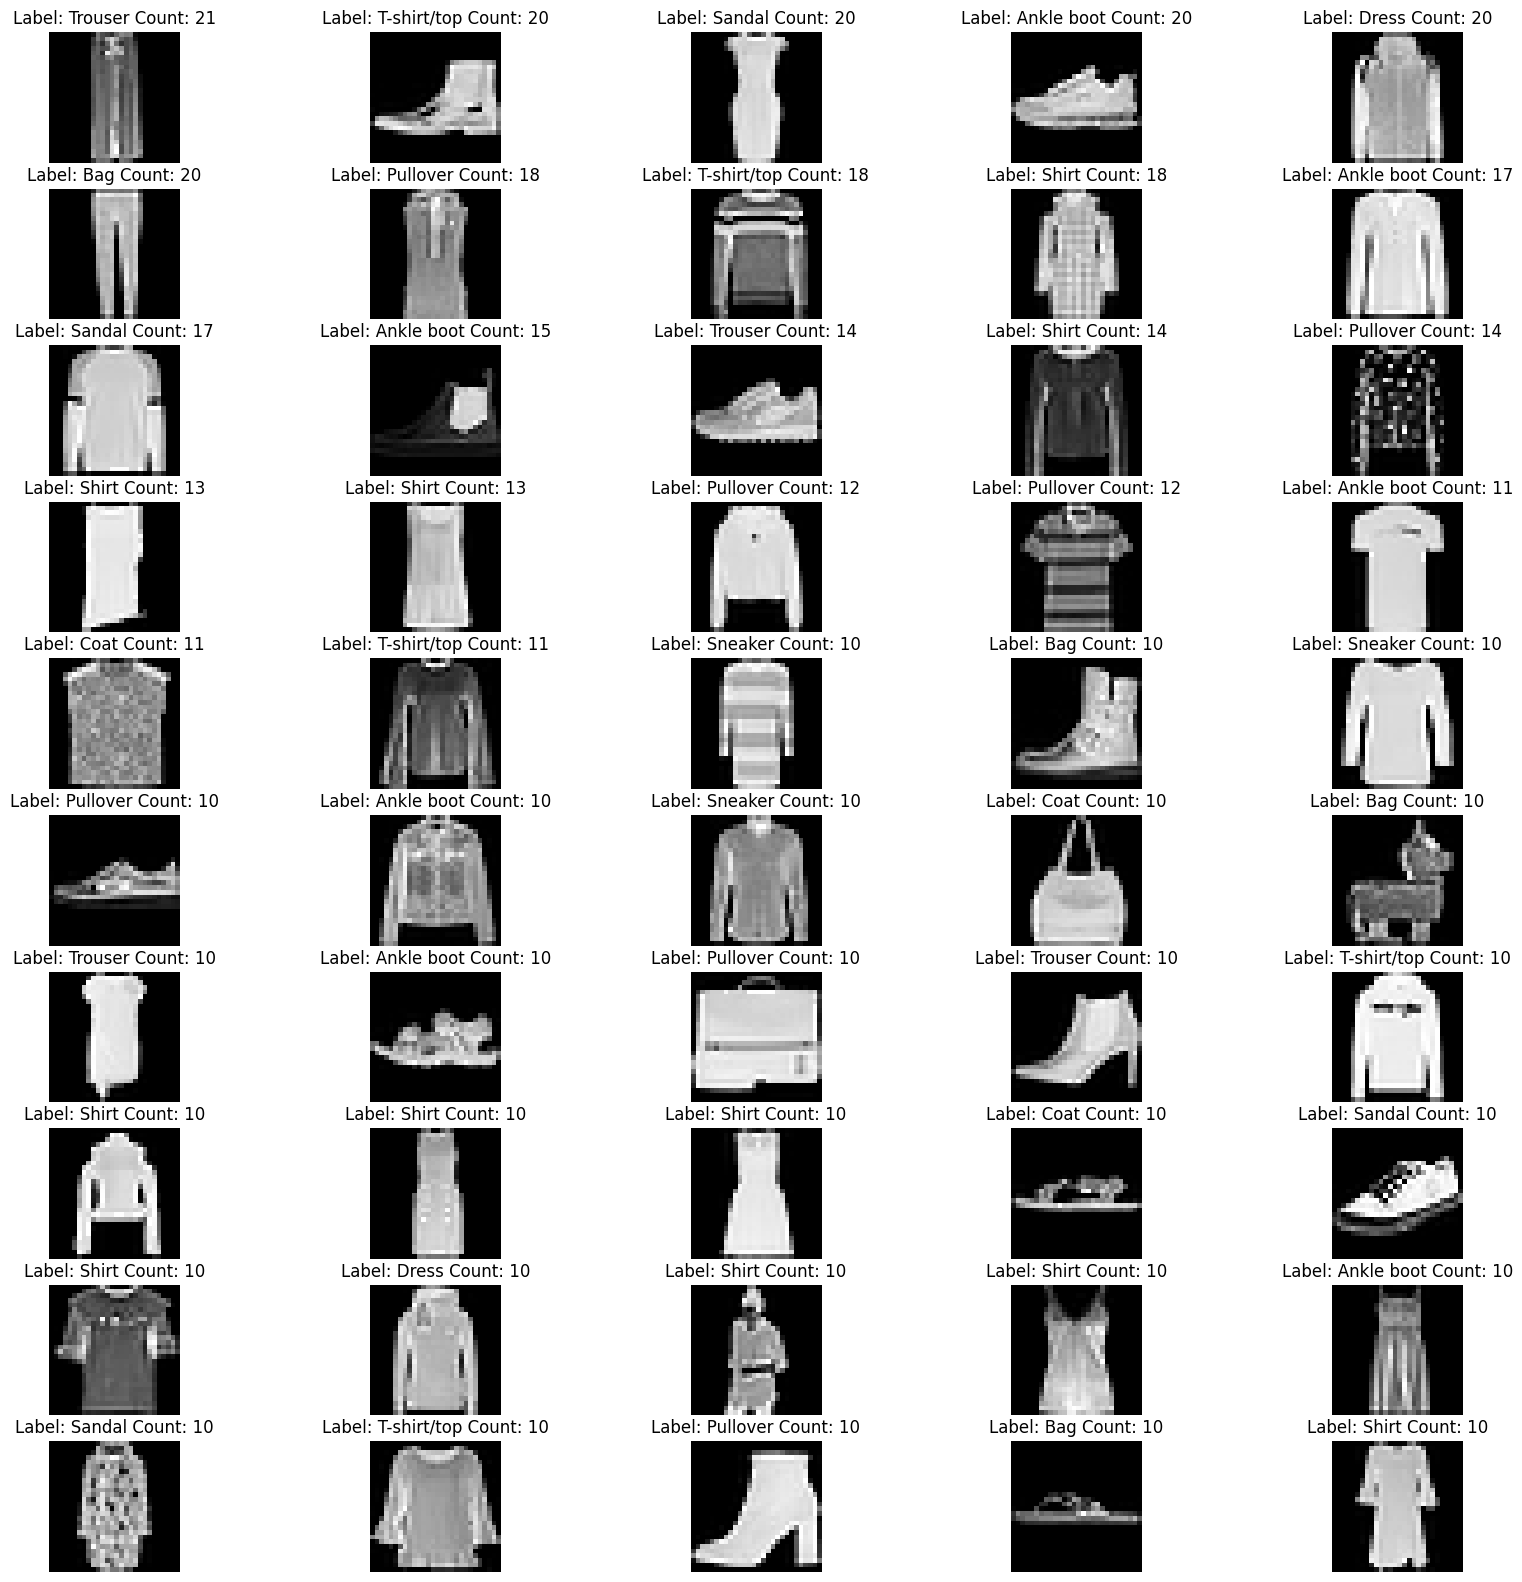

In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sorted_wrong_predictions = sorted(wrong_preds.items(), key=lambda item: item[1], reverse=True)

transform1 = transforms.ToTensor()
transform2 = transforms.ToPILImage()
sorted_indoces = []
plt.figure(figsize=(20, 20))
for i, (idx, count) in enumerate(sorted_wrong_predictions[:50]):
    sorted_indoces.append(idx)
    img, label = test_dataset[idx]
    img = transform2(transform1(img))
    plt.subplot(10, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {class_names[label]} Count: {count}")
    plt.axis('off')
plt.show()


In [11]:
real_noises = test_noise_adder.get_noisy_indices()

s = [idx for (idx, count) in wrong_preds.items() if count >= 10]
counts = [count for (idx, count) in wrong_preds.items()]

acc = test_noise_adder.calculate_noised_label_percentage(s)

89.39857288481141% accuracy in 981 data


(array([1.270e+03, 5.010e+02, 2.930e+02, 2.120e+02, 1.077e+03, 5.000e+00,
        5.000e+00, 1.000e+00, 5.000e+00, 6.000e+00]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <BarContainer object of 10 artists>)

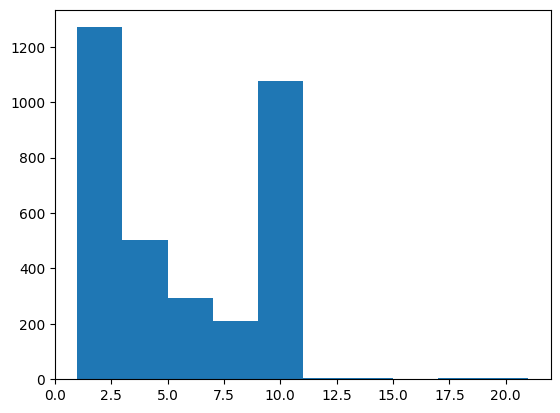

In [12]:
plt.hist(counts)

## CIFAR10

In [4]:
train_dataset = CIFAR10(root='data', train=True, download=True)
test_dataset = CIFAR10(root='data', train=False, download=True)

train_noise_adder = LabelNoiseAdder(train_dataset, noise_level=0.1, num_classes=10)
train_noise_adder.add_noise()

test_noise_adder = LabelNoiseAdder(test_dataset, noise_level=0.1, num_classes=10)
test_noise_adder.add_noise()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_detector = NoiseDetector(SiameseNetwork, train_dataset, device, model_save_path="cifar10/resnet18/model_resnet18_cifar10_fold_{}.pth", batch_size=300, transform=transform)
noise_detector.train_models(num_epochs=10)